In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#
#

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
import numpy as np
# import tensorflow as tf
from sklearn.preprocessing import scale

In [3]:
def windows(nrows, size):
    start,step = 0, 2
    while start < nrows:
        yield start, start + size
        start += step

def segment_signal(features,labels,window_size = 15):
    segments = np.empty((0,window_size))
    segment_labels = np.empty((0))
    nrows = len(features)
    for (start, end) in windows(nrows,window_size):
        if(len(data.iloc[start:end]) == window_size):
            segment = features[start:end].T  #Transpose to get segment of size 24 x 15 
            label = labels[(end-1)]
            segments = np.vstack([segments,segment]) 
            segment_labels = np.append(segment_labels,label)
    segments = segments.reshape(-1,24,window_size,1) # number of features  = 24 
    segment_labels = segment_labels.reshape(-1,1)
    return segments,segment_labels

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/ericlrf/Estimation-of-Remaining-Useful-Life-using-CNN/master/PHM08.csv")
features = scale(data.iloc[:,2:26]) # select required columns and scale them
labels = data.iloc[:,26] # select RUL 

In [5]:
segments, labels = segment_signal(features,labels)

In [6]:
train_test_split = np.random.rand(len(segments)) < 0.70
train_x = segments[train_test_split]
train_y = labels[train_test_split]
test_x = segments[~train_test_split]
test_y = labels[~train_test_split]

--------------------------------------------------------------------------------------------------------------------------------

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def apply_conv(x,kernel_height,kernel_width,num_channels,depth):
    weights = weight_variable([kernel_height, kernel_width, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(tf.nn.conv2d(x, weights,[1,1,1,1],padding="VALID"),biases))
    
def apply_max_pool(x,kernel_height,kernel_width,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_height, kernel_width, 1], strides=[1, 1, stride_size, 1], padding = "VALID")

In [8]:
num_labels = 1
batch_size = 10
num_hidden = 800
learning_rate = 0.0001
training_epochs = 30
input_height = 24
input_width = 15
num_channels = 1
total_batches = train_x.shape[0] // batch_size

In [9]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.compat.v1.placeholder(tf.float32, shape=[None,num_labels])
# X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
# Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_conv(X, kernel_height = 24, kernel_width = 4, num_channels = 1, depth = 8) 
p = apply_max_pool(c,kernel_height = 1, kernel_width = 2, stride_size = 2) 
c = apply_conv(p, kernel_height = 1, kernel_width = 3, num_channels = 8, depth = 14) 
p = apply_max_pool(c,kernel_height = 1, kernel_width = 2, stride_size = 2) 

shape = p.get_shape().as_list()
flat = tf.reshape(p, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * shape[3], num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.add(tf.matmul(f, out_weights),out_biases)

In [10]:
cost_function = tf.reduce_mean(tf.square(y_- Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

In [44]:
train_mse = []
test_mse = []
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Training set MSE")
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size),:]
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, Y : batch_y})
            
        p_tr = session.run(y_, feed_dict={X:  train_x})
        tr_mse = tf.reduce_mean(tf.square(p_tr - train_y))
        train_mse.append(session.run(tr_mse)) 
        print(train_mse[-1])

    p_ts = session.run(y_, feed_dict={X:  test_x})
    ts_mse = tf.reduce_mean(tf.square(p_ts - test_y))
    test_mse.append(session.run(ts_mse))
    print("Test set MSE: %.4f" % test_mse[-1]) 

Training set MSE
4765.775701468718
4682.2916590297755
4680.168980934526
4678.964539342199
4668.81241126378
4635.368776166393
4579.7327852415165
4498.660402579265
4384.243424849911
4231.702490067251
4049.3423404685577
3857.9062793859002
3667.817762836181
3499.3956258906096
3356.4478796099047
3233.561861195541
3129.646565519125
3037.9421796215956
2960.061923302212
2891.958890872887
2833.788605123142
2781.6681692891502
2734.8344977311813
2695.3826945524306
2657.708431798455
2621.550442069863
2588.341502094438
2556.079005988116
2525.24311927246
2497.2415212645224
Test set MSE: 2513.4512


In [46]:
len(train_mse)

30

In [47]:
for i in range(len(train_mse)-1):
  test_mse.append(test_mse[-1])

len(test_mse)

30

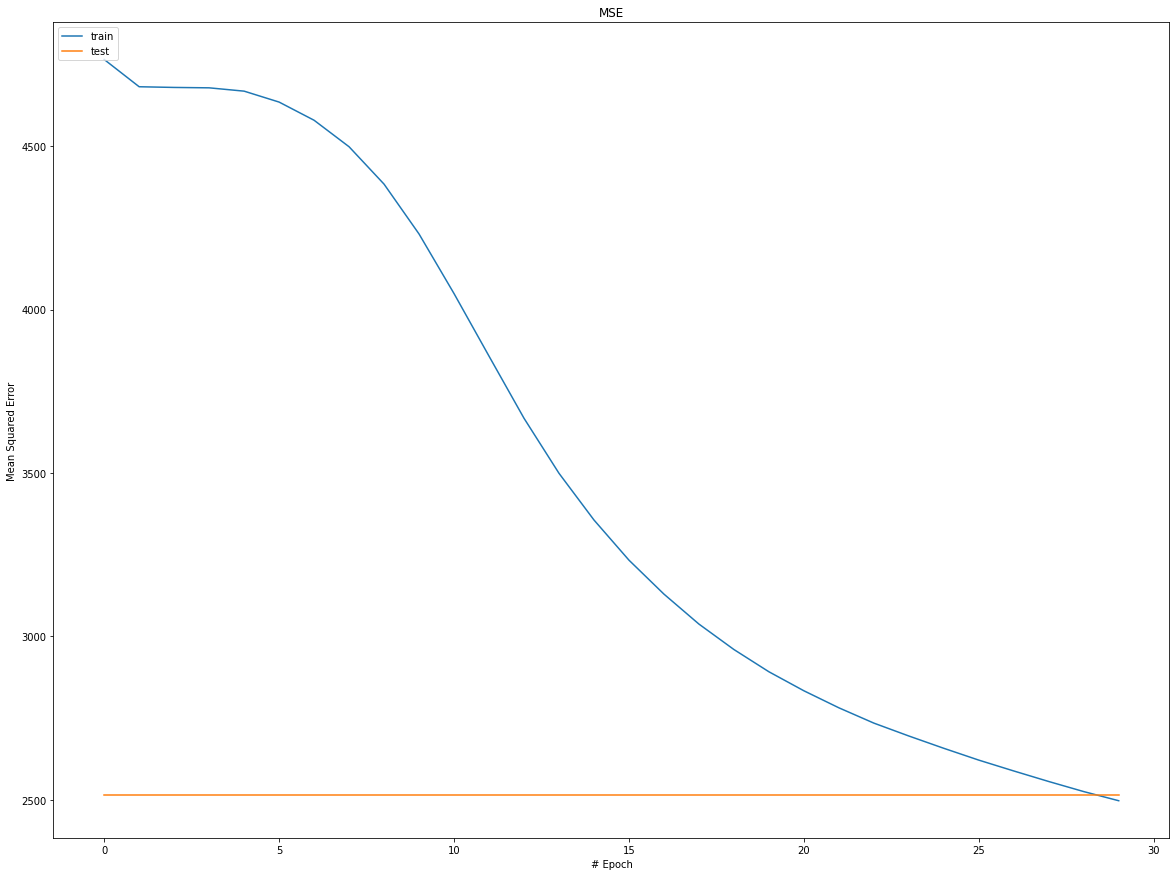

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(train_mse)
plt.plot(test_mse)
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
